## Import Block

In [262]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10

# from torchmetrics import 
import random
import numpy as np
import matplotlib.pyplot as plt

from LogTracker import IntegerTracker

import copy
import math
import time 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE, torch.__version__

('cuda', '2.5.1+cu118')

In [263]:
LOWER, UPPER = 0.2, 0.8

In [264]:
torch.manual_seed(24)

## Transforms

In [266]:
transform_v1 = transforms.Compose([ ### VER 1
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_v2 = transforms.Compose([ ###VER 2
    transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Augmentation
    transforms.RandomRotation(15),  # Rotate by ±15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shifting
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.2)  # Randomly erase parts of the image
])

transform = transforms.Compose([ ###VER 3
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of mirroring
    transforms.RandomRotation(10),  # Rotate by ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = CIFAR10(root='data', download=True ,transform=transform, train=True)
test_dataset = CIFAR10(root='data', download=True ,transform=transform, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [267]:
len(train_dataset)

50000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


(32, 32, 3)

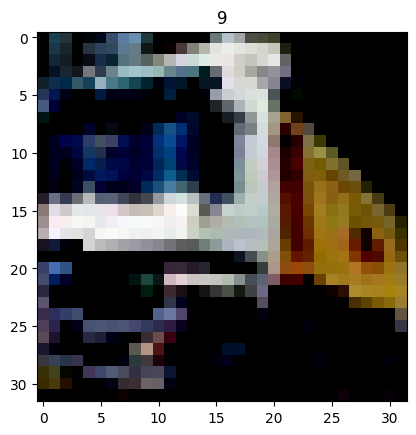

In [268]:
img, lab = train_dataset[1]
img= img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.title(lab)
img.shape

In [269]:
num_classes = len(train_dataset.classes)
num_classes

10

In [270]:
def NoiseLabels(dataset : CIFAR10, lower=LOWER, upper=UPPER, noise_rate=None):
    if noise_rate == None:
        noise_rate = random.uniform(lower, upper)
    
    targets = np.array(dataset.targets)
    n_samples = len(targets)
    
    noise_bools = np.random.rand(n_samples) < noise_rate
    true_vals = np.sum(noise_bools)

    #
    print(f"Mask Info...\n\tExpected Noise Rate: {noise_rate:.3f} | Actual Noise Rate: {true_vals/len(noise_bools) : .3f} | Samples : {(len(noise_bools))}")

    for i in range(len(noise_bools)):
        if not noise_bools[i]:
            continue

        original_label = targets[i]

        def RandomLabel():
            random_label = np.random.choice(targets)
            return random_label if random_label != original_label else RandomLabel()
        new_label = RandomLabel()
        targets[i] = new_label
    dataset.targets = targets.tolist()
    return dataset
# train_data = datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
train_data_noise = NoiseLabels(copy.deepcopy(train_dataset))


Mask Info...
	Expected Noise Rate: 0.494 | Actual Noise Rate:  0.494 | Samples : 50000


## Noisy Dataset - Inherited Class

In [272]:
class NoisyDataset(CIFAR10):
    def __init__(self, root='data', transform=None, train=True, download=True, lower=LOWER, upper=UPPER):
            
        super().__init__(root=root, train=train, transform=transform, download=download)
        self.noise_rate = 0.2 + (0.8 - 0.2) * torch.rand(1).item()
        self.noise_rate = 0.3
        # print(f"Randomly chosen noise rate: {self.noise_rate}")
        # self.classes = len(self.classes)
        self.__Corrupt()

    def __Corrupt(self):
        targets = torch.tensor(self.targets)

        n_samples = targets.size(0)
        
        noise_bools = torch.rand(n_samples) < self.noise_rate
        
        #
        true_vals = noise_bools.sum().item()
        print(f"Mask Info...\n\tExpected Noise Rate: {self.noise_rate:.3f} | Actual Noise Rate: {true_vals/len(noise_bools) : .3f} | True/False : {true_vals/(len(noise_bools) - true_vals) :.3f}")
        
        for i in range(len(noise_bools)):
            if not noise_bools[i]:
                continue
            
            original_label = targets[i]
            new_label = self.__ChooseRandomLabel(original_label, targets)
            targets[i] = new_label
            
        self.targets = targets.tolist()

    @staticmethod
    def __ChooseRandomLabel(original_label, targets):
        possible_labels = list(range(num_classes))
        possible_labels.remove(original_label)
        new_label = possible_labels[torch.randint(0, len(possible_labels), (1,)).item()]
        return new_label
train_data_noise = NoisyDataset(root='data', train=True, transform=transform)

Files already downloaded and verified
Mask Info...
	Expected Noise Rate: 0.300 | Actual Noise Rate:  0.301 | True/False : 0.430


## Normalized Cross Entropy - V1

In [274]:
class NormalizedCrossEntropyLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(NormalizedCrossEntropyLoss, self).__init__()
        self.reduction = reduction
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        # Compute standard cross-entropy loss
        ce_loss = self.cross_entropy(logits, targets)
        
        # Compute the entropy of the target distribution
        target_probs = torch.softmax(logits, dim=-1)
        entropy = -torch.sum(target_probs * torch.log(target_probs + 1e-12), dim=-1)

        # Normalize the cross-entropy loss by entropy
        normalized_loss = ce_loss / (entropy + 1e-12)

        if self.reduction == 'mean':
            return normalized_loss.mean()
        elif self.reduction == 'sum':
            return normalized_loss.sum()
        else:
            return normalized_loss

## Normalized Cross Entropy - V2 REVISED

In [276]:
class NormalizedCrossEntropyLoss_REVISED(nn.Module):
    def __init__(self, reduction='mean'):
        super(NormalizedCrossEntropyLoss_REVISED, self).__init__()
        self.reduction = reduction
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')  # Keep 'none' for per-sample loss

    def forward(self, logits, targets):
        # Compute standard cross-entropy loss
        ce_loss = self.cross_entropy(logits, targets)
        
        # Compute the entropy of the target distribution
        target_probs = torch.softmax(logits, dim=-1)
        entropy = -torch.sum(target_probs * torch.log(target_probs + 1e-12), dim=-1)

        # Normalize the cross-entropy loss by entropy
        normalized_loss = ce_loss / (entropy + 1e-12)

        # Apply reduction
        if self.reduction == 'mean':
            return normalized_loss.mean()  # Scalar
        elif self.reduction == 'sum':
            return normalized_loss.sum()  # Scalar
        else:
            return normalized_loss  # No reduction, returns a tensor


In [277]:
classes = train_data_noise.classes

## Dataloaders && Batch Size

In [279]:
BATCH_SIZE = 256

train_data_loader = DataLoader(
    train_data_noise, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

test_data_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

len(train_data_loader), len(test_data_loader)

(195, 39)

In [280]:
def show_images_with_labels(data_loader, class_names, num_images=16):
    images, labels = next(iter(data_loader))
    
    grid_size = int(np.sqrt(num_images))
    assert grid_size ** 2 == num_images, "num_images must be a perfect square."
    
    images = images.permute(0, 2, 3, 1).numpy()  # Convert to (batch_size, height, width, channels)
    images = (images * 0.5) + 0.5  # Assuming images were normalized to [-1, 1]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    fig.suptitle("Images and Labels", fontsize=16)
    
    for i, ax in enumerate(axes.flatten()):
        if i >= num_images:
            break
        ax.imshow(images[i])
        ax.axis("off") 
        ax.set_title(class_names[labels[i].item()], fontsize=10, color="black")
    
    plt.tight_layout()
    plt.show()


# show_images_with_labels(train_data_loader, classes, num_images=16)

## Model - V1

In [282]:

class CNN_V1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 32x32 -> 16x16
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 16x16 -> 8x8
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 4, out_channels=hidden_units * 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 4 * 4 * 4, out_features=256),  # Flattened size: 4x4x(hidden_units * 4)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=output_shape)  # Output size: number of classes
        )

    def forward(self, x, print_dims=False):
        y_b1 = self.block1(x)
        y_b2 = self.block2(y_b1)
        y_b3 = self.block3(y_b2)
        y = self.classifier(y_b3)
        if print_dims:
            print(f"{y_b1.shape=}")
            print(f"{y_b2.shape=}")
            print(f"{y_b3.shape=}")
            print(f"{y.shape=}")
        return y
"""
model = CNN_V1(
    input_shape=3, #3 color channels
    hidden_units=32,
    output_shape=len(classes)
)
model
"""

'\nmodel = CNN_V1(\n    input_shape=3, #3 color channels\n    hidden_units=32,\n    output_shape=len(classes)\n)\nmodel\n'

## Model - V2

In [284]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


model = SimpleCNN(num_classes=num_classes)
model

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

## Loss Function & Optimizer - V1

In [286]:
# loss_fn_cnn = NormalizedCrossEntropyLoss_REVISED(model)
# loss_fn_cnn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

## Loss Function & Optimizer - V2

In [288]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs
criterion = NormalizedCrossEntropyLoss_REVISED(model)

## Loss Function & Optimizer - V3

In [290]:
# optimizer = torch.optim.AdamW(
#     model.parameters(),  # Ensure `model` is defined
#     lr=0.001,            # Initial learning rate
#     betas=(0.9, 0.999),  # Default values for AdamW
#     eps=1e-8,            # Small epsilon value for numerical stability
#     weight_decay=0.01    # L2 regularization strength
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)
# criterion = NormalizedCrossEntropyLoss_REVISED(model)

In [291]:
criterion, optimizer, scheduler

(NormalizedCrossEntropyLoss_REVISED(
   (reduction): SimpleCNN(
     (conv_layers): Sequential(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
       (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (5): ReLU()
       (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (9): ReLU()
       (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (12): ReLU()
       (13): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Test Accuracy 

In [293]:
def evaluate_model(model, dataloader, loss_fn, device='cuda'):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss = loss.mean() if loss.dim() > 0 else loss

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / total
    test_acc = correct / total

    
    model.train()
    return test_loss, test_acc
    
# test_loss, test_acc = evaluate_model(model, test_data_loader, device=DEVICE)

## Train Loop - V1

In [295]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            # print("Logits range:", outputs.min().item(), outputs.max().item())
            loss = loss_fn(outputs, labels)
            loss = loss.mean() if loss.dim() > 0 else loss
            # print(f"Loss shape: {loss.shape}")

            
            # Backward pass
            model.train()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            #ADD Testaccruracy
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        test_loss, test_acc = evaluate_model(model, test_data_loader, device=DEVICE)
        test_loss, test_acc = 0,0
        print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}") 

# Train the model
# train_model(model, train_data_loader, optimizer, loss_fn=loss_fn_cnn, num_epochs=10, device=DEVICE)

### Termination flag checker and logger for remote logger

In [297]:
def check_termination_flag(file_path="TFlag.txt"):
    try:
        with open(file_path, 'r') as file:  # Open the file in read mode
            content = file.read().strip()  # Read the content and remove any extra whitespace
            if content == '0':
                print("Received Termination Signal. Terminating...")
                return True  # Terminate the loop
            elif content == '1':
                return False  # Continue the loop
            else:
                print(f"Unexpected content in file: {content}. Expected '0' or '1'. Terminating Process...")
                return True  # Continue the loop by default
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return False  # Continue the loop if the file doesn't exist
    except Exception as e:
        print(f"Error reading {e}. Terminating Process...")
        return True  # Continue the loop in case of other errors|
def log(message):
    tracker = IntegerTracker()
    path = f"Logs\\Log_{tracker.read_value()}.txt"
    with open(path, "a") as f:
        f.write(f"{time.strftime('%Y-%m-%d %H:%M:%S')} - {message}\n")

arch = [criterion.state_dict, optimizer.state_dict, scheduler.state_dict()]
for i in arch:
    log(i)
    log('\n')

## Train Loop - V2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

INCLUDE_TEST = True

num_epochs = 100  # Train for more epochs

train_losses, train_accuracies, test_losses, test_accuracies = torch.Tensor(num_epochs), torch.Tensor(num_epochs), torch.Tensor(num_epochs), torch.Tensor(num_epochs)



start_time = time.time()
for epoch in range(num_epochs):
    if check_termination_flag():
        log("Termination Train Loop (Manual)")
        break
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss.mean() if loss.dim() > 0 else loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    #Test Accuracy:
    test_loss, test_acc = 0,0
    if INCLUDE_TEST:
        model.eval()
        test_loss, test_acc = evaluate_model(model, test_data_loader, criterion, device=DEVICE)
        model.train()
    test_losses[epoch] = test_loss
    test_accuracies[epoch] = test_acc
    
    scheduler.step()  # Adjust LR
    

    
    train_loss = total_loss/len(train_data_loader)
    train_accuracy = correct/total
    train_losses[epoch] = train_loss
    train_accuracies[epoch] = train_accuracy
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} | Time Stamp: {(time.time()-start_time):.3f} s")
    log(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
end_time = time.time()
train_time = end_time-start_time
print(f"Train Time : {train_time:.6f}s")

Epoch 1/100 | Train Loss: 0.9514, Train Accuracy: 0.2709 | Test Loss: 0.8387, Test Accuracy: 0.4757 | Time Stamp: 23.511 s
Epoch 2/100 | Train Loss: 0.9199, Train Accuracy: 0.3474 | Test Loss: 0.8125, Test Accuracy: 0.5234 | Time Stamp: 48.207 s
Epoch 3/100 | Train Loss: 0.9061, Train Accuracy: 0.3809 | Test Loss: 0.7994, Test Accuracy: 0.5443 | Time Stamp: 72.969 s
Epoch 4/100 | Train Loss: 0.8963, Train Accuracy: 0.4059 | Test Loss: 0.7789, Test Accuracy: 0.5681 | Time Stamp: 97.657 s
Epoch 5/100 | Train Loss: 0.8877, Train Accuracy: 0.4249 | Test Loss: 0.7664, Test Accuracy: 0.6076 | Time Stamp: 122.398 s
Epoch 6/100 | Train Loss: 0.8805, Train Accuracy: 0.4416 | Test Loss: 0.7543, Test Accuracy: 0.6423 | Time Stamp: 147.192 s
Epoch 7/100 | Train Loss: 0.8738, Train Accuracy: 0.4561 | Test Loss: 0.7498, Test Accuracy: 0.6447 | Time Stamp: 172.000 s
Epoch 8/100 | Train Loss: 0.8687, Train Accuracy: 0.4665 | Test Loss: 0.7425, Test Accuracy: 0.6682 | Time Stamp: 196.764 s
Epoch 9/100 

In [ ]:

def LogLossesAndAccuracy(metrics, arch, info):
    try:
        tracker = IntegerTracker()
        path = f"Logs\\Log_{tracker.read_value()}.txt"
        with open(path, "a") as f:
            
            for i in arch:
                f.write(f"{i}\n\n")
            # for values,msg in zip(metrics,msgs):
            #     for i in range(values.shape[0]):
            #         f.write(f"Epoch {i+1} | {msg}: {values[i]:.4f}\n")
            
            f.write(f"\nKey Info:\n{info}\n\n")
            
            # for i in range(len(accuracies)):
            #     f.write(f"Epoch {i+1} | Loss: {losses[i]:.4f} | Accuracy: {accuracies[i]:.4f}\n")
            length = len(metrics[next(iter(metrics))])
            for i in range(length):
                metric_msg = ""
                metric_msg += f"\nEpoch {i} | "
                for metric_name, values in metrics.items():
                    metric_msg += f"{metric_name}: {values[i]:.4f}"
                    metric_msg += " | " if metric_name!=list(metrics.keys())[-1] else ""
                f.write(f"{metric_msg}")
                
        print(f"Logged File | {path = }")
        tracker.increment_value()
    except FileExistsError:
        print("Already exists.")
    
            

In [ ]:
metrics = {
    "Train Accuracy":train_accuracies,
    "Train Loss":train_losses,
    "Test Loss":test_losses,
    "Test Accuracy":test_accuracies
}
info = f"Noise Rate: {train_data_noise.noise_rate:.4f} \nTrain Time: {train_time:.6f}s \nTransforms: HOR_FLIP ROT_10 NORM \nLoss({criterion.__class__}) \nOptimizer({optimizer.__class__}) \nScheduler({scheduler.__class__})"
# LogLossesAndAccuracy(metrics, arch = [criterion.state_dict, optimizer.state_dict, scheduler.state_dict()], info=info)

In [ ]:
def plot_metrics(metrics):
    """
    Plots all arrays in the dictionary on the same graph.
    
    :param metrics: A dictionary where keys are strings (metric names) and values are arrays (metric values).
    """
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Iterate over the dictionary and plot each array
    for metric_name, values in metrics.items():
        x_values = range(len(values))  # Use indices as the x-axis
        plt.plot(x_values, values, linestyle='-', label=metric_name)
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Metrics')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

In [ ]:

plot_metrics(metrics)


In [ ]:
tracker = IntegerTracker()

torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'criterion_state_dict':criterion.state_dict(),
    'scheduler_state_dict':scheduler.state_dict(),
    'metrics':metrics
}, f'Models\\cnn_{tracker.read_value()-1}.pth')


In [ ]:
tracker = IntegerTracker()
tracker.increment_value()

In [ ]:
tracker.read_value()